In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx") #./../../data/Preise.xlsx   - Pfad für Sandbox
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

In [3]:
df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

In [4]:
df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

In [5]:
def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "transaction_id"]], on="transaction_id"))

df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

In [6]:
# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifische Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

In [7]:
dataframes_online = [
    df_regAo,
    df_regBo,
    df_regCo,
    df_regDo
]

dataframes_a = [
    df_regAo,
    df_regAp,
    df_regAs
]

dataframes_b = [
    df_regBo,
    df_regBp,
    df_regBs
]

dataframes_c = [
    df_regCo,
    df_regCp,
    df_regCs
]

dataframes_d = [
    df_regDo,
    df_regDp,
    df_regDs
]

df_a = pd.concat(dataframes_a, ignore_index=True)
df_b = pd.concat(dataframes_b, ignore_index=True)
df_c = pd.concat(dataframes_c, ignore_index=True)
df_d = pd.concat(dataframes_d, ignore_index=True)

df_online = pd.concat(dataframes_online, ignore_index=True)
df_online

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,44,170.02,850.10,529,2645,358.98,1794.90,7.1,A,online
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,44,170.02,1190.14,529,3703,358.98,2512.86,5.9,A,online
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,44,210.03,1470.21,529,3703,318.97,2232.79,7.5,A,online
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,44,170.08,1700.80,529,5290,358.92,3589.20,6.6,A,online
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,44,170.09,680.36,529,2116,358.91,1435.64,7.3,A,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84994,2022-10-31,Tablet Mini,1.0,3,0,1,0,NaN,136.06,NaN,...,44,136.06,408.18,550,1650,413.94,1241.82,6.1,D,online
84995,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.06,NaN,...,44,136.06,136.06,550,550,413.94,413.94,8.0,D,online
84996,2022-10-31,Tablet Mini,1.0,2,0,1,0,NaN,136.06,NaN,...,44,136.06,272.12,550,1100,413.94,827.88,7.5,D,online
84997,2022-10-31,Tablet Mini,1.0,1,0,1,0,NaN,136.02,NaN,...,44,136.02,136.02,550,550,413.98,413.98,6.8,D,online


<Axes: xlabel='date'>

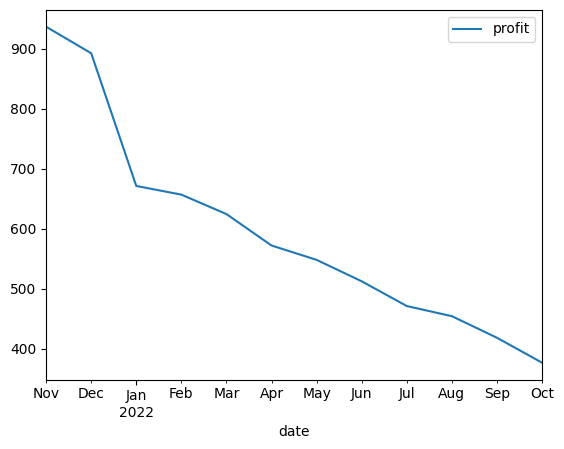

In [8]:
profit_per_week_all = df_reg_main.groupby(pd.Grouper(key="date", freq="1M")).agg({"profit": "mean"}) # Umsatz pro Monat -> Klarer Umsatzrückgang

profit_per_week_all.plot()

In [9]:
df_dt

,year,a,b,c,d
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


In der Übersicht der Downtime kann man erkennen, dass die Downtime in A und B erheblich steigt, während diese in C und D stagniert. Nun steht die Hypothese im Raum, dass aufgrund dieses Umstandes das Kaufverhalten der Kunden im Online Umfeld verändert wurde.

<Axes: xlabel='date'>

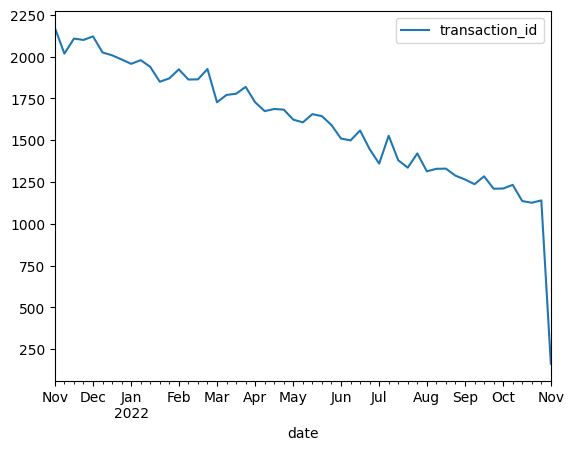

In [10]:
trans_per_week_all = df_online.groupby(pd.Grouper(key="date", freq="1W")).agg({"transaction_id": "count"})

trans_per_week_all.plot()

<Axes: xlabel='date', ylabel='profit'>

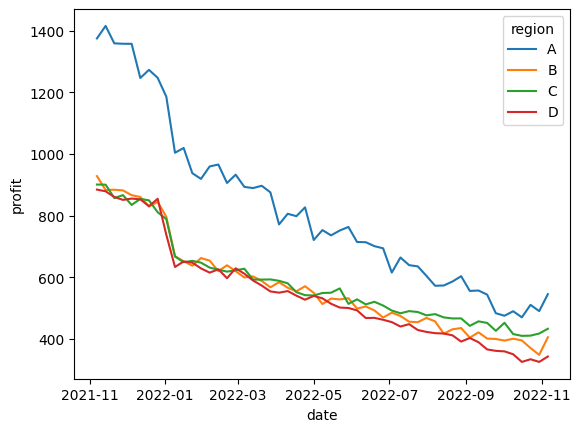

In [11]:
profit_per_week_vis = df_reg_main.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"profit": "mean"})
sns.lineplot(data=profit_per_week_vis, x="date", y="profit", hue="region")

<Axes: xlabel='date', ylabel='revenue'>

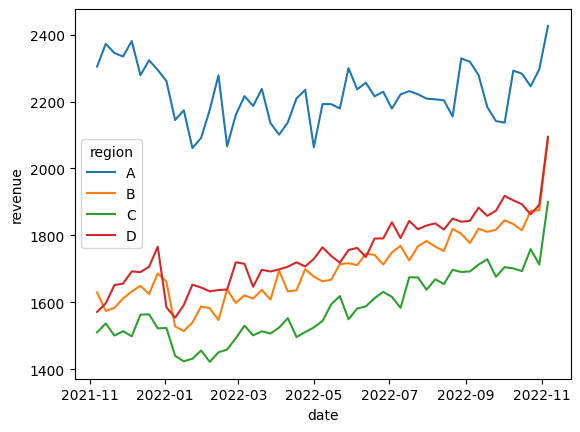

In [12]:
rev_per_week_vis = df_reg_main.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"revenue": "mean"})
sns.lineplot(data=rev_per_week_vis, x="date", y="revenue", hue="region")

<Axes: xlabel='date', ylabel='transaction_id'>

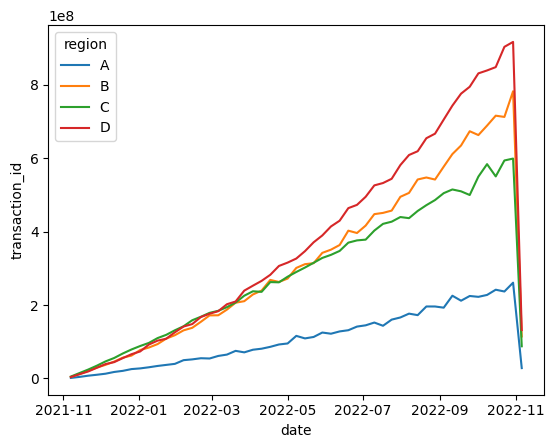

In [13]:
trans_per_week_vis = df_reg_main.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"transaction_id": "sum"})
sns.lineplot(data=trans_per_week_vis, x="date", y="transaction_id", hue="region")

<Axes: xlabel='date', ylabel='revenue'>

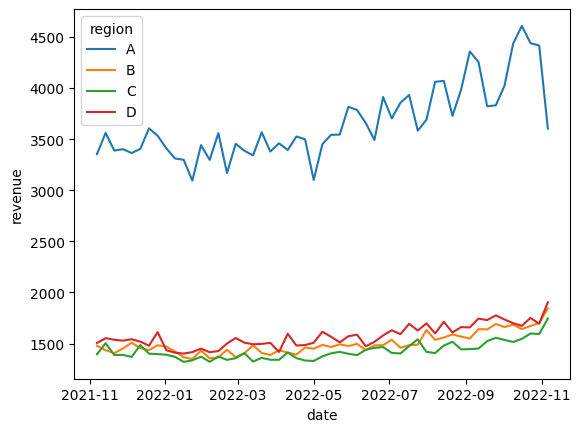

In [14]:
rev_per_week_online = df_online.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"revenue": "mean"})
sns.lineplot(data=rev_per_week_online, x="date", y="revenue", hue="region")

<Axes: xlabel='date', ylabel='profit'>

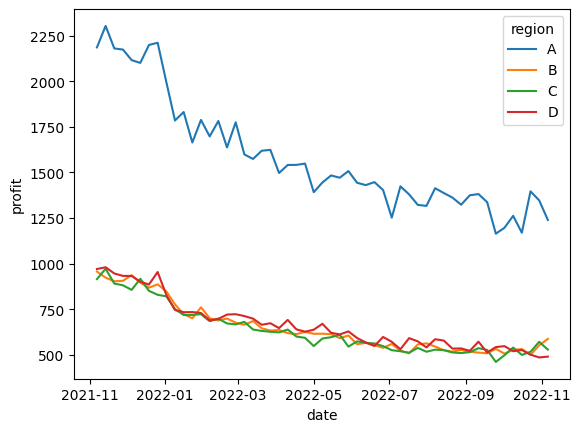

In [15]:
profit_per_week_online = df_online.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"profit": "mean"})
sns.lineplot(data=profit_per_week_online, x="date", y="profit", hue="region")

<Axes: xlabel='date', ylabel='transaction_id'>

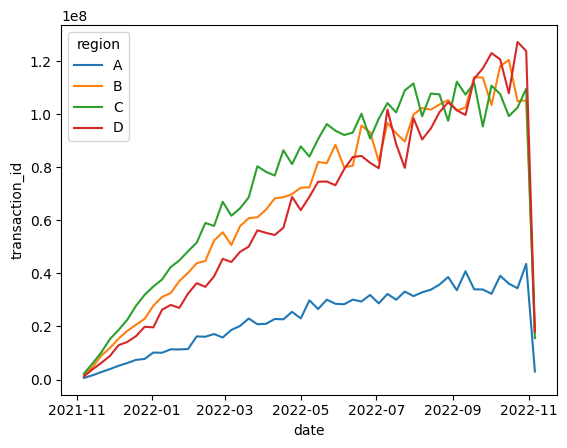

In [16]:
trans_per_week_online = df_online.groupby(["region", pd.Grouper(key="date", freq="1W")]).agg({"transaction_id": "sum"})
sns.lineplot(data=trans_per_week_online, x="date", y="transaction_id", hue="region")

In [17]:
df_dt

,year,a,b,c,d
0,2021,0.10,0.01,0.05,0.00
1,2022,0.15,0.15,0.04,0.01


In [21]:
df_online.plot(x="region", y="profit", kind="box")